# Product Image Similarity Search with CLIP

Pure visual similarity matching using CLIP embeddings:
1. Generate CLIP embeddings for all product images
2. Find visually similar products using cosine similarity
3. Optional: Use GPT-4.1 for final verification

## Setup and Dependencies

Install required packages for CLIP model and image processing.

In [ ]:
# Run this to install the necessary packages for using the CLIP model
!pip install transformers torch torchvision torchaudio

## Initialize Models and Libraries
### CLIP Model
Embeddings for images are offered in the API by some providers (Google, for instance) but unfortunately not OpenAI. To avoid having to deal with Google service accounts and access we'll use the local CLIP model.

CLIP is a model from OpenAI that links images and text in a shared representation space. It turns images into embeddings—numerical vectors that capture semantic meaning—so we can measure how similar two images are.

We use CLIP because it allows us to perform similarity search on images: given a query image, we can find other images that look alike or share visual characteristics.

In [1]:
import base64
import os
from pathlib import Path
from typing import List, Optional, Dict, Any

import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from openai import OpenAI
from pydantic import BaseModel, Field
from sklearn.metrics.pairwise import cosine_similarity

# Initialize
client = OpenAI()
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

print(f"✅ CLIP model loaded on {device}")

/Users/jakobfriberg/Documents/AI/ai-bootcamp/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ CLIP model loaded on cpu


In [2]:
class SimilarityMatch(BaseModel):
    image_id: str
    is_same_product: bool
    confidence_score: float = Field(ge=0.0, le=1.0)
    reasoning: str

class ProductMatchResult(BaseModel):
    query_image_path: str
    matches: List[SimilarityMatch]
    best_match_id: Optional[str]
    summary: str

In [3]:
def get_clip_embedding(image_path: str) -> np.ndarray:
    """Generate CLIP visual embedding for an image"""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    return image_features.cpu().numpy().flatten()

def encode_image(image_path: str) -> str:
    """Encode image as base64 for OpenAI API"""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

print("✅ Helper functions ready")

✅ Helper functions ready


# Product Database
We initialize a product database for storing embeddings and doing similarity search

In [4]:
class ProductDatabase:
    def __init__(self):
        self.products = {}
        self.embeddings = {}
    
    def add_product(self, product_id: str, image_path: str):
        self.products[product_id] = {"id": product_id, "image_path": image_path}
        self.embeddings[product_id] = get_clip_embedding(image_path)
        print(f"Added {product_id}")
    
    def find_similar(self, query_embedding: np.ndarray, top_k: int = 5) -> List[str]:
        if not self.embeddings:
            return []
        
        ids = list(self.embeddings.keys())
        vectors = np.stack([self.embeddings[pid] for pid in ids])
        similarities = cosine_similarity([query_embedding], vectors)[0]
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        return [ids[i] for i in top_indices]
    
    def get_similarities(self, query_embedding: np.ndarray, product_ids: List[str]) -> List[float]:
        vectors = np.stack([self.embeddings[pid] for pid in product_ids if pid in self.embeddings])
        if len(vectors) == 0:
            return []
        return cosine_similarity([query_embedding], vectors)[0].tolist()
    
    def size(self) -> int:
        return len(self.products)

db = ProductDatabase()
print("✅ Database ready")

✅ Database ready


In [5]:
images_dir = Path("sample_product_images")
image_files = list(images_dir.glob("*.jpg"))

print(f"Found {len(image_files)} images")
print("Building database...")

for img_path in image_files:
    db.add_product(img_path.stem, str(img_path))

print(f"✅ Database built with {db.size()} products")

Found 45 images
Building database...


/Users/jakobfriberg/Documents/AI/ai-bootcamp/.venv/lib/python3.13/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Added 375
Added 411
Added 404
Added 376
Added 438
Added 616
Added 400
Added 401
Added 371
Added 417
Added 563
Added 562
Added 358
Added 314
Added 665
Added 517
Added 516
Added 313
Added 652
Added 647
Added 335
Added 308
Added 522
Added 325
Added 496
Added 327
Added 535
Added 332
Added 483
Added 369
Added 340
Added 426
Added 368
Added 418
Added 430
Added 435
Added 347
Added 583
Added 352
Added 608
Added 436
Added 581
Added 556
Added 594
Added 351
✅ Database built with 45 products


In [6]:
def find_similar_products(query_image_path: str, top_k: int = 5) -> ProductMatchResult:
    """Find similar products using CLIP embeddings"""
    
    # Get CLIP embedding for query
    query_embedding = get_clip_embedding(query_image_path)
    
    # Find similar products
    similar_ids = db.find_similar(query_embedding, top_k)
    similarities = db.get_similarities(query_embedding, similar_ids)
    
    # Create matches
    matches = []
    for i, product_id in enumerate(similar_ids):
        score = similarities[i] if i < len(similarities) else 0.0
        is_match = score > 0.85
        
        matches.append(SimilarityMatch(
            image_id=product_id,
            is_same_product=is_match,
            confidence_score=min(score, 0.95),
            reasoning=f"CLIP similarity: {score:.3f}"
        ))
    
    best_match = next((m.image_id for m in matches if m.is_same_product), None)
    
    return ProductMatchResult(
        query_image_path=query_image_path,
        matches=matches,
        best_match_id=best_match,
        summary=f"Found {len([m for m in matches if m.is_same_product])} potential matches"
    )

print("✅ Search function ready")

✅ Search function ready


# Testing
## Simple similarity test
First we do a simple test to see if the similarity search works

In [7]:
query_image = image_files[5]

print(f"🔍 Testing with: {query_image.name}")
print("="*50)

result = find_similar_products(str(query_image))

print(f"Summary: {result.summary}")
print("\nTop matches:")

for i, match in enumerate(result.matches, 1):
    status = "✅ MATCH" if match.is_same_product else "❌ NO MATCH"
    print(f"{i}. {match.image_id}: {status} ({match.confidence_score:.3f})")

if result.best_match_id:
    print(f"\n🏆 Best match: {result.best_match_id}")

🔍 Testing with: 616.jpg
Summary: Found 1 potential matches

Top matches:
1. 616: ✅ MATCH (0.950)
2. 556: ❌ NO MATCH (0.789)
3. 436: ❌ NO MATCH (0.787)
4. 581: ❌ NO MATCH (0.784)
5. 563: ❌ NO MATCH (0.784)

🏆 Best match: 616


## Similarity search together with GPT-4.1

In [8]:
def analyze_with_gpt(query_image_path: str, candidate_paths: List[str], candidate_ids: List[str]) -> ProductMatchResult:
    """Use GPT-4.1 to analyze if candidates match the query"""
    
    content = [{
        "type": "input_text",
        "text": f"Compare the first image to these candidates: {candidate_ids}. Which show the same exact product?"
    }]
    
    # Add query image
    content.append({
        "type": "input_image",
        "image_url": f"data:image/jpeg;base64,{encode_image(query_image_path)}"
    })
    
    # Add candidate images
    for i, img_path in enumerate(candidate_paths):
        content.extend([
            {"type": "input_text", "text": f"Candidate {candidate_ids[i]}:"},
            {"type": "input_image", "image_url": f"data:image/jpeg;base64,{encode_image(img_path)}"}
        ])
    
    response = client.responses.parse(
        model="gpt-4.1",
        input=[{"role": "user", "content": content}],
        text_format=ProductMatchResult
    )
    
    return response.output_parsed

print("✅ GPT-4.1 reasoning function ready")

✅ GPT-4.1 reasoning function ready


Let's test with an image we know exist in the database.

🤖 TESTING GPT-4.1 MULTI-MODAL REASONING
📸 Query: 376.jpg


/Users/jakobfriberg/Documents/AI/ai-bootcamp/.venv/lib/python3.13/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


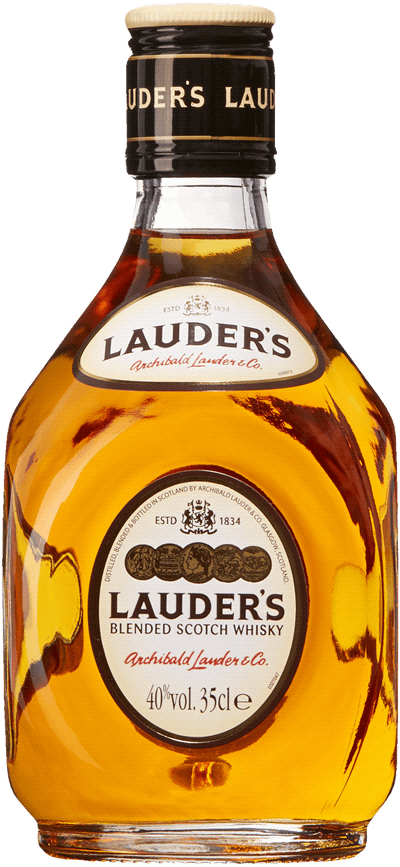

🔍 CLIP found 3 similar images


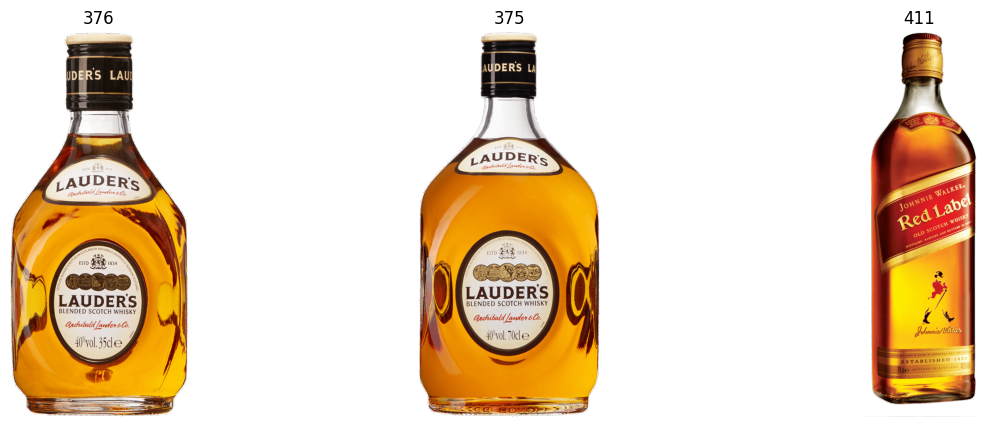


🧠 Sending to GPT-4.1 for reasoning...

📊 GPT-4.1 RESULTS:
Summary: Candidate 376 shows the exact same product as the query image. Candidate 375 is a similar but different size, and Candidate 411 is a different product.

Detailed analysis:
  376: ✅ MATCH (confidence: 1.000)
    Reasoning: The label design, brand name (LAUDER'S), text, seal, and bottle shape are identical in both images, including the 35cl and 40% vol. details.
  375: ❌ NO MATCH (confidence: 0.700)
    Reasoning: The label, brand, and design are extremely similar, but the size and some details are different (70cl instead of 35cl). This suggests it is the same product line but not the exact same product.
  411: ❌ NO MATCH (confidence: 0.000)
    Reasoning: The brand (Johnnie Walker) and label are completely different from the query image, making this a different product.

🏆 GPT-4.1 selected: 376


In [9]:
from IPython.display import display, Image as NotebookImage
from PIL import Image
import matplotlib.pyplot as plt

query_image = image_files[3]

print("🤖 TESTING GPT-4.1 MULTI-MODAL REASONING")
print("=" * 60)

clip_result = find_similar_products(str(query_image), top_k=3)

print(f"📸 Query: {query_image.name}")
display(NotebookImage(filename=str(query_image)))

print(f"🔍 CLIP found {len(clip_result.matches)} similar images")

candidate_paths = []
candidate_ids = []

for match in clip_result.matches:
    img_path = db.products[match.image_id]["image_path"]
    candidate_paths.append(img_path)
    candidate_ids.append(match.image_id)

# Display candidates side by side
fig, axes = plt.subplots(1, len(candidate_paths), figsize=(5 * len(candidate_paths), 5))
if len(candidate_paths) == 1:
    axes = [axes]
for ax, path, cid in zip(axes, candidate_paths, candidate_ids):
    ax.imshow(Image.open(path))
    ax.set_title(cid)
    ax.axis("off")
plt.show()

print("\n🧠 Sending to GPT-4.1 for reasoning...")

try:
    gpt_result = analyze_with_gpt(str(query_image), candidate_paths, candidate_ids)
    
    print("\n📊 GPT-4.1 RESULTS:")
    print(f"Summary: {gpt_result.summary}")
    
    print("\nDetailed analysis:")
    for match in gpt_result.matches:
        status = "✅ MATCH" if match.is_same_product else "❌ NO MATCH"
        print(f"  {match.image_id}: {status} (confidence: {match.confidence_score:.3f})")
        print(f"    Reasoning: {match.reasoning}")
    
    if gpt_result.best_match_id:
        print(f"\n🏆 GPT-4.1 selected: {gpt_result.best_match_id}")
    else:
        print("\n❌ GPT-4.1 found no exact matches")
        
except Exception as e:
    print(f"❌ Error with GPT-4.1 analysis: {e}")


Now, let's challenge the system and crop the image to only show one part of the image.

In [ ]:
from IPython.display import display, Image as NotebookImage
from PIL import Image
import matplotlib.pyplot as plt

query_image = image_files[3]

print("🤖 TESTING GPT-4.1 MULTI-MODAL REASONING")
print("=" * 60)

# --- Crop step (take left half of the image) ---
img = Image.open(query_image)
width, height = img.size
cropped_img = img.crop((0, 0, width, height // 2))  # top half
cropped_path = "cropped_query.jpg"
cropped_img.save(cropped_path)

# Use cropped image for similarity search
clip_result = find_similar_products(cropped_path, top_k=3)

print(f"📸 Query (cropped): {query_image.name}")
display(NotebookImage(filename=cropped_path))

print(f"🔍 CLIP found {len(clip_result.matches)} similar images")

candidate_paths = []
candidate_ids = []

for match in clip_result.matches:
    img_path = db.products[match.image_id]["image_path"]
    candidate_paths.append(img_path)
    candidate_ids.append(match.image_id)

# Display candidates side by side
fig, axes = plt.subplots(1, len(candidate_paths), figsize=(5 * len(candidate_paths), 5))
if len(candidate_paths) == 1:
    axes = [axes]
for ax, path, cid in zip(axes, candidate_paths, candidate_ids):
    ax.imshow(Image.open(path))
    ax.set_title(cid)
    ax.axis("off")
plt.show()

print("\n🧠 Sending to GPT-4.1 for reasoning...")

try:
    gpt_result = analyze_with_gpt(cropped_path, candidate_paths, candidate_ids)
    
    print("\n📊 GPT-4.1 RESULTS:")
    print(f"Summary: {gpt_result.summary}")
    
    print("\nDetailed analysis:")
    for match in gpt_result.matches:
        status = "✅ MATCH" if match.is_same_product else "❌ NO MATCH"
        print(f"  {match.image_id}: {status} (confidence: {match.confidence_score:.3f})")
        print(f"    Reasoning: {match.reasoning}")
    
    if gpt_result.best_match_id:
        print(f"\n🏆 GPT-4.1 selected: {gpt_result.best_match_id}")
    else:
        print("\n❌ GPT-4.1 found no exact matches")
        
except Exception as e:
    print(f"❌ Error with GPT-4.1 analysis: {e}")


# YOLO

In [6]:
# YOLO Bottle Detection and Cropping Cell (Fixed Version)
import torch
import cv2
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pathlib import Path
import os
import shutil

def load_yolo_model(model_path="yolo_drinks.pt", force_reload=True):
    """Load the YOLO model for drink detection with cache clearing"""
    try:
        # Clear YOLOv5 cache to avoid compatibility issues
        cache_dir = Path.home() / ".cache" / "torch" / "hub" / "ultralytics_yolov5_master"
        if cache_dir.exists() and force_reload:
            print(f"🧹 Clearing YOLOv5 cache: {cache_dir}")
            shutil.rmtree(cache_dir)
        
        # Load model with force_reload=True
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=force_reload)
        print(f"✅ YOLO model loaded from {model_path}")
        return model
    except Exception as e:
        print(f"❌ Error loading YOLO model: {e}")
        print("�� Trying alternative loading method...")
        
        try:
            # Alternative: Load directly with ultralytics
            from ultralytics import YOLO
            model = YOLO(model_path)
            print(f"✅ YOLO model loaded using ultralytics from {model_path}")
            return model
        except Exception as e2:
            print(f"❌ Alternative loading also failed: {e2}")
            return None

def detect_and_crop_bottles(image_path, model, confidence_threshold=0.5):
    """
    Detect bottles in an image and crop the bounding boxes
    
    Args:
        image_path: Path to the input image
        model: Loaded YOLO model
        confidence_threshold: Minimum confidence for detection
    
    Returns:
        List of dictionaries containing cropped images and metadata
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return []
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Run YOLO detection - handle both ultralytics and torch.hub models
    try:
        if hasattr(model, 'predict'):  # ultralytics YOLO
            results = model.predict(image_rgb, conf=confidence_threshold)
            detections = results[0].boxes.data.cpu().numpy()  # x1, y1, x2, y2, confidence, class
        else:  # torch.hub YOLO
            results = model(image_rgb)
            detections = results.xyxy[0].cpu().numpy()  # x1, y1, x2, y2, confidence, class
    except Exception as e:
        print(f"❌ Error during detection: {e}")
        return []
    
    cropped_bottles = []
    
    for i, detection in enumerate(detections):
        x1, y1, x2, y2, confidence, class_id = detection
        
        if confidence >= confidence_threshold:
            # Ensure coordinates are within image bounds
            x1, y1, x2, y2 = max(0, int(x1)), max(0, int(y1)), min(image_rgb.shape[1], int(x2)), min(image_rgb.shape[0], int(y2))
            
            # Check if bounding box is valid
            if x2 > x1 and y2 > y1:
                # Crop the bottle
                cropped = image_rgb[y1:y2, x1:x2]
                
                # Convert to PIL Image for consistency with existing code
                cropped_pil = Image.fromarray(cropped)
                
                # Save cropped image
                base_name = Path(image_path).stem
                cropped_filename = f"{base_name}_bottle_{i}.jpg"
                cropped_path = cropped_filename
                cropped_pil.save(cropped_path)
                
                bottle_info = {
                    'id': f"{base_name}_bottle_{i}",
                    'cropped_image': cropped_pil,
                    'cropped_path': cropped_path,
                    'bbox': (x1, y1, x2, y2),
                    'confidence': float(confidence),
                    'class_id': int(class_id),
                    'original_image': image_path
                }
                
                cropped_bottles.append(bottle_info)
                print(f"�� Detected bottle {i+1}: confidence={confidence:.3f}, bbox=({x1}, {y1}, {x2}, {y2})")
    
    return cropped_bottles

def visualize_detections(image_path, cropped_bottles):
    """Visualize the original image with bounding boxes and cropped bottles"""
    # Load original image
    original = Image.open(image_path)
    
    # Create figure with subplots
    n_bottles = len(cropped_bottles)
    if n_bottles == 0:
        print("❌ No bottles detected to visualize")
        return
    
    fig, axes = plt.subplots(1, n_bottles + 1, figsize=(5 * (n_bottles + 1), 5))
    if n_bottles == 0:
        axes = [axes]
    
    # Show original image with bounding boxes
    draw = ImageDraw.Draw(original)
    for bottle in cropped_bottles:
        x1, y1, x2, y2 = bottle['bbox']
        draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
        draw.text((x1, y1-20), f"Bottle {bottle['confidence']:.2f}", fill='red')
    
    axes[0].imshow(original)
    axes[0].set_title(f"Original Image\n({n_bottles} bottles detected)")
    axes[0].axis('off')
    
    # Show cropped bottles
    for i, bottle in enumerate(cropped_bottles):
        axes[i+1].imshow(bottle['cropped_image'])
        axes[i+1].set_title(f"Bottle {i+1}\nConf: {bottle['confidence']:.3f}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

def process_image_with_yolo(image_path, confidence_threshold=0.5):
    """
    Complete pipeline: Load YOLO model, detect bottles, crop them, and make available
    
    Args:
        image_path: Path to the input image
        confidence_threshold: Minimum confidence for detection
    
    Returns:
        List of cropped bottle dictionaries ready for similarity search
    """
    print(f"🔍 Processing image: {image_path}")
    print("=" * 50)
    
    # Load YOLO model with cache clearing
    model = load_yolo_model(force_reload=True)
    if model is None:
        print("❌ Failed to load YOLO model. Please check if yolo_drinks.pt exists in the current directory.")
        return []
    
    # Detect and crop bottles
    cropped_bottles = detect_and_crop_bottles(image_path, model, confidence_threshold)
    
    if not cropped_bottles:
        print("❌ No bottles detected in the image")
        return []
    
    print(f"✅ Successfully detected and cropped {len(cropped_bottles)} bottles")
    
    # Visualize results
    visualize_detections(image_path, cropped_bottles)
    
    # Make cropped images available for similarity search
    print("\n📋 Available cropped bottles for similarity search:")
    for i, bottle in enumerate(cropped_bottles):
        print(f"  {i+1}. {bottle['id']} (confidence: {bottle['confidence']:.3f})")
        print(f"     Path: {bottle['cropped_path']}")
        print(f"     Size: {bottle['cropped_image'].size}")
    
    return cropped_bottles

# Integration with existing similarity search
def find_similar_products_for_bottles(cropped_bottles, top_k=5):
    """
    Use the existing similarity search to find matches for each cropped bottle
    
    Args:
        cropped_bottles: List of cropped bottle dictionaries from YOLO detection
        top_k: Number of top matches to return
    
    Returns:
        Dictionary mapping bottle IDs to similarity search results
    """
    results = {}
    
    for bottle in cropped_bottles:
        print(f"\n🔍 Finding similar products for {bottle['id']}...")
        
        # Use existing similarity search function
        similarity_result = find_similar_products(bottle['cropped_path'], top_k)
        results[bottle['id']] = similarity_result
        
        print(f"Summary: {similarity_result.summary}")
        for i, match in enumerate(similarity_result.matches[:3], 1):  # Show top 3
            status = "✅ MATCH" if match.is_same_product else "❌ NO MATCH"
            print(f"  {i}. {match.image_id}: {status} ({match.confidence_score:.3f})")
    
    return results

# Complete pipeline example
def complete_bottle_analysis_pipeline(image_path, confidence_threshold=0.2, top_k=5):
    """
    Complete pipeline: YOLO detection → cropping → similarity search
    
    Args:
        image_path: Path to the input image
        confidence_threshold: YOLO confidence threshold
        top_k: Number of top similarity matches
    
    Returns:
        Tuple of (cropped_bottles, similarity_results)
    """
    print("🚀 Starting complete bottle analysis pipeline")
    print("=" * 60)
    
    # Step 1: YOLO detection and cropping
    cropped_bottles = process_image_with_yolo(image_path, confidence_threshold)
    
    if not cropped_bottles:
        print("❌ No bottles found, ending pipeline")
        return [], {}
    
    # Step 2: Similarity search for each bottle
    print("\n🔍 Starting similarity search for detected bottles...")
    similarity_results = find_similar_products_for_bottles(cropped_bottles, top_k)
    
    print("\n✅ Pipeline completed successfully!")
    return cropped_bottles, similarity_results

🚀 Running YOLO detection on: sample_product_images/340.jpg
✅ YOLO model loaded from yolo_drinks.pt
🔍 Running detection on sample_product_images/340.jpg
 Image size: 400x1639

0: 640x160 (no detections), 32.3ms
Speed: 0.6ms preprocess, 32.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 160)
🎯 Raw detections found: 0


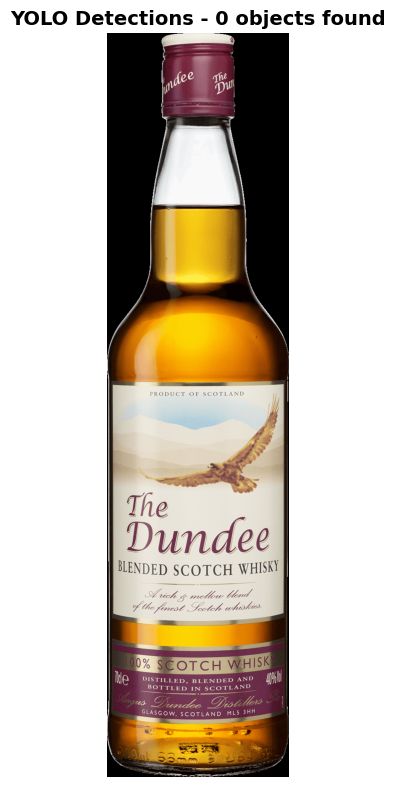


✅ Visualization complete - 0 detections shown


In [27]:
# YOLO Detection with Bounding Box Visualization
%matplotlib inline
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def load_yolo_model_simple(model_path="yolo_drinks.pt"):
    """Load YOLO model"""
    try:
        from ultralytics import YOLO
        model = YOLO(model_path)
        print(f"✅ YOLO model loaded from {model_path}")
        return model
    except ImportError:
        try:
            model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)
            print(f"✅ YOLO model loaded from {model_path}")
            return model
        except Exception as e:
            print(f"❌ Failed to load YOLO model: {e}")
            return None

def visualize_detections_with_boxes(image_path, model):
    """
    Run YOLO detection and visualize with matplotlib bounding boxes
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    print(f"🔍 Running detection on {image_path}")
    print(f" Image size: {image_rgb.shape[1]}x{image_rgb.shape[0]}")
    
    # Run detection with no confidence threshold
    try:
        if hasattr(model, 'predict'):  # ultralytics YOLO
            results = model.predict(image_rgb, conf=0.3)  # Show everything
            detections = results[0].boxes.data.cpu().numpy()
        else:  # torch.hub YOLO
            results = model(image_rgb)
            detections = results.xyxy[0].cpu().numpy()
    except Exception as e:
        print(f"❌ Error during detection: {e}")
        return
    
    print(f"🎯 Raw detections found: {len(detections)}")
    
    # Create matplotlib figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Display the image
    ax.imshow(image_rgb)
    
    # Add bounding boxes for all detections
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta']
    
    for i, detection in enumerate(detections):
        x1, y1, x2, y2, confidence, class_id = detection
        
        # Calculate box dimensions
        width = x2 - x1
        height = y2 - y1
        
        # Create rectangle patch
        color = colors[i % len(colors)]
        rect = patches.Rectangle((x1, y1), width, height, 
                               linewidth=2, edgecolor=color, facecolor='none')
        
        # Add rectangle to plot
        ax.add_patch(rect)
        
        # Add text label
        ax.text(x1, y1-5, f'#{i+1}: {confidence:.3f}', 
               color=color, fontsize=10, weight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        #print(f"  Detection {i+1}: conf={confidence:.4f}, bbox=({int(x1)}, {int(y1)}, {int(x2)}, {int(y2)})")
    
    # Set title and remove axes
    ax.set_title(f'YOLO Detections - {len(detections)} objects found', fontsize=14, weight='bold')
    ax.axis('off')
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Visualization complete - {len(detections)} detections shown")

# Simple function to run detection and visualize
def run_yolo_visualization(image_path):
    """
    Run YOLO detection and visualize with matplotlib bounding boxes
    """
    print(f"🚀 Running YOLO detection on: {image_path}")
    print("=" * 50)
    
    # Load model
    model = load_yolo_model_simple()
    if model is None:
        print("❌ Could not load YOLO model")
        return
    
    # Run detection and visualize
    visualize_detections_with_boxes(image_path, model)

# Test with saison.jpg
run_yolo_visualization("sample_product_images/340.jpg")